# process stats from netcdf single trajectory data files

In [1]:
import os
from glob import glob
import pickle

import numpy as np
import xarray as xr
import dask.bag as db
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import mitequinox.drifters as edr
import mitequinox.utils as eut

#data_dir = '/work/ALT/swot/aval/syn/drifters/'
data_dir = eut.work_data_dir+'drifters/'

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=6, walltime='12:00:00', memory='20GB')
w = cluster.scale(40)
#w = cluster.scale(10) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)
#client = Client()

In [4]:
#client
cluster

In [ ]:
#client.close()
cluster.close()

---
## utils

In [6]:
lon_bins = np.arange(-180.5, 180.5, 1.)
lat_bins = np.arange(-90.5, 91.5, 1.)

lon_c = (lon_bins[:-1]+lon_bins[1:])*.5
lat_c = (lat_bins[:-1]+lat_bins[1:])*.5

lon_idx = pd.IntervalIndex.from_breaks(lon_bins)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
lonlat_idx = pd.MultiIndex.from_product([lon_idx, lat_idx])

---

## load raw data as xarray dataset and then a dataframe

In [7]:
ds = xr.open_dataset(data_dir+'raw/driftertrajGPS_1.02.nc')
ds = ds.chunk({'TIME':24*1000})
ds['GPS'] = (1 + ds.U*0.).astype(int)
ds_GPS = ds

In [8]:
ncfile = data_dir+'raw/driftertrajWMLE_1.02_block1.nc'
ds = xr.open_mfdataset(data_dir+'raw/driftertrajWMLE_1.02_block*.nc')
ds = ds.chunk({'TIME':24*1000})
ds['GPS'] = (0. + ds.U*0.).astype(int)
ds_ARGOS = ds
#print(ds)

In [9]:
ds = xr.concat([ds_GPS, ds_ARGOS], dim='TIME')
ds['LON'] = eut.fix_lon_bounds(ds['LON'])

In [10]:
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))
ds

Dataset size = 15.5 GB


<xarray.Dataset>
Dimensions:  (TIME: 148752886)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2001-07-01T02:00:00 ... NaT
Data variables:
    ID       (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    LAT      (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    LON      (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    LAT_ERR  (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    LON_ERR  (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    U        (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    V        (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    U_ERR    (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    V_ERR    (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    GAP      (TIME) timedelta64[ns] dask.array<shape=(148752886,), chunksize=(24000,)>
    DROGUE   (TIME) float64 dask.array<shape=(148752886,), chu

In [11]:
# convert to dataframe
df = ds.to_dask_dataframe()
df
# could persist right away

,TIME,ID,LAT,LON,LAT_ERR,LON_ERR,U,V,U_ERR,V_ERR,GAP,DROGUE,GPS
npartitions=6199,,,,,,,,,,,,,
0,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,float64,float64,timedelta64[ns],float64,int64
24000,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148734737,...,...,...,...,...,...,...,...,...,...,...,...,...
148752885,...,...,...,...,...,...,...,...,...,...,...,...,...


---

## start massaging to get diagnostics

In [12]:
# add velocity products
df['U2'] = df['U']*df['U']
df['V2'] = df['V']*df['V']
df['UV'] = df['U']*df['V']

In [13]:
# bin longitude and latitude for groupby
df['LON_binned'] = df['LON'].map_partitions(pd.cut, lon_bins, meta=(None,'f8'))
df['LAT_binned'] = df['LAT'].map_partitions(pd.cut, lat_bins, meta=(None,'f8'))

In [14]:
df = df.persist()
# 67GB in memory at this stage

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask/blockwise.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  contains = index in indices
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask/blockwise.py:595: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  sub[blockwise_token(i)] = blockwise_token(indices.index(index))


---

## compute diagnostics

In [15]:
df_meancount = (df.drop(['ID','TIME'],axis=1).groupby(['LON_binned','LAT_binned'])
                .aggregate(['mean','count']).compute())
#df_mean = df.groupby(['LON_binned','LAT_binned']).mean().compute()

In [16]:
df_meancount.head()

LAT               LON        \
                                      mean count        mean count   
LON_binned       LAT_binned                                          
(-180.5, -179.5] (-77.5, -76.5] -76.931941    79 -179.718952    79   
                 (-76.5, -75.5] -75.956183    55 -179.692855    55   
                 (-75.5, -74.5] -74.985907    72 -179.810330    72   
                 (-74.5, -73.5] -73.770683     3 -179.935097     3   
                 (-71.5, -70.5] -70.511522    37 -179.685926    37   

                                    LAT_ERR           LON_ERR               U  \
                                       mean count        mean count      mean   
LON_binned       LAT_binned                                                     
(-180.5, -179.5] (-77.5, -76.5]  100.658228    79  445.392405    79 -0.041994   
                 (-76.5, -75.5]  116.745455    55  480.945455    55 -0.002022   
                 (-75.5, -74.5]  139.513889    72  537.680556    72 -0.006481   
                 (-74.5, -73.5]  181.333333     3  647.666667     3  0.152533   
                 (-71.5, -70.5]  146.378378    37  439.162162    37 -0.033059   

                                       ...    DROGUE        GPS        \
                                count  ...      mean count mean count   
LON_binned       LAT_binned            ...                              
(-180.5, -179.5] (-77.5, -76.5]    79  ...  1.000000    79  1.0    79   
                 (-76.5, -75.5]    55  ...  0.254545    55  1.0    55   
                 (-75.5, -74.5]    72  ...  0.000000    72  1.0    72   
                 (-74.5, -73.5]     3  ...  0.000000     3  1.0     3   
                 (-71.5, -70.5]    37  ...  0.783784    37  1.0    37   

                                       U2              V2              UV  \
                                     mean count      mean count      mean   
LON_binned       LAT_binned                                                 
(-180.5, -179.5] (-77.5, -76.5]  0.023002    79  0.021053    79 -0.003133   
                 (-76.5, -75.5]  0.026543    55  0.052648    55  0.007060   
                 (-75.5, -74.5]  0.029945    72  0.085887    72  0.004302   
                 (-74.5, -73.5]  0.023363     3  0.070575     3  0.039946   
                 (-71.5, -70.5]  0.015767    37  0.019860    37 -0.014477   

                                       
                                count  
LON_binned       LAT_binned            
(-180.5, -179.5] (-77.5, -76.5]    79  
                 (-76.5, -75.5]    55  
                 (-75.5, -74.5]    72  
                 (-74.5, -73.5]     3  
                 (-71.5, -70.5]    37  

[5 rows x 28 columns]

In [36]:
datadict = {v: (['lon', 'lat'], df_meancount[v]['mean'].reindex(lonlat_idx).unstack().values) for v in ['U','V', 'U2', 'V2', 'UV']}
datadict['COUNT'] = (['lon', 'lat'], df_meancount['U']['count'].reindex(lonlat_idx).unstack().values)

In [37]:
ds = xr.Dataset(datadict, coords = {'lon': lon_c, 'lat': lat_c})

In [38]:
ds

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    U        (lon, lat) float64 nan nan nan nan ... nan -0.02582 0.2797 -0.0807
    V        (lon, lat) float64 nan nan nan nan ... nan 0.1025 -0.0283 -0.053
    U2       (lon, lat) float64 nan nan nan nan ... nan 0.01712 0.07918 0.006512
    V2       (lon, lat) float64 nan nan nan nan ... 0.01571 0.0008749 0.002809
    UV       (lon, lat) float64 nan nan nan nan ... -0.001538 -0.008177 0.004277
    COUNT    (lon, lat) float64 nan nan nan nan nan nan ... nan nan 26.0 2.0 1.0

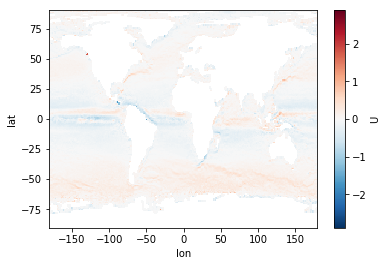

In [39]:
ds.U.plot(x='lon',y='lat')

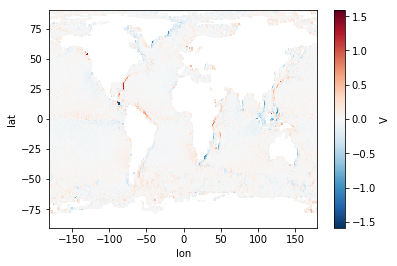

In [40]:
ds.V.plot(x='lon',y='lat')

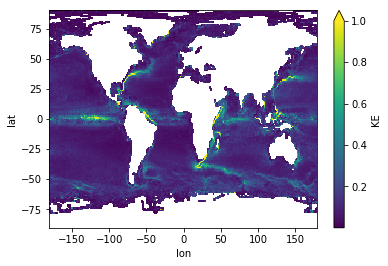

In [41]:
(ds.U2+ds.V2).rename('KE').plot(x='lon',y='lat',vmax=1.)

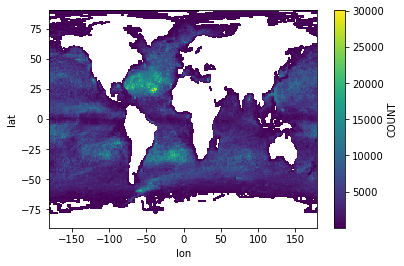

In [42]:
ds.COUNT.plot(x='lon',y='lat')

In [43]:
# add depth
depth = xr.open_dataset(eut.work_data_dir+'bathy/ETOPO1_Ice_g_gmt4.grd')
depth['x2'] = (depth.x+0.*depth.y).transpose()
depth['y2'] = (0.*depth.x+depth.y).transpose()
depth

<xarray.Dataset>
Dimensions:  (x: 21601, y: 10801)
Coordinates:
  * x        (x) float64 -180.0 -180.0 -180.0 -179.9 ... 179.9 180.0 180.0 180.0
  * y        (y) float64 -90.0 -89.98 -89.97 -89.95 ... 89.95 89.97 89.98 90.0
Data variables:
    z        (y, x) float64 ...
    x2       (y, x) float64 -180.0 -180.0 -180.0 -179.9 ... 180.0 180.0 180.0
    y2       (y, x) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1_Ice_g_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  0

In [44]:
# without averaging
depth_noav = depth.z.sel(x=ds.lon,y=ds.lat, method='nearest', tolerance=0.1)

# with averaging
h, edges1, edges2 = np.histogram2d(depth.x2.values.flatten(), depth.y2.values.flatten(), 
                                   bins=[lon_bins, lat_bins], weights=depth.z.values.flatten(), 
                                   density=False)
hcount, edges1, edges2 = np.histogram2d(depth.x2.values.flatten(), depth.y2.values.flatten(), 
                                       bins=[lon_bins, lat_bins],
                                       density=False)
ds['depth'] = xr.DataArray((h/hcount), coords=[ds.lon,ds.lat])

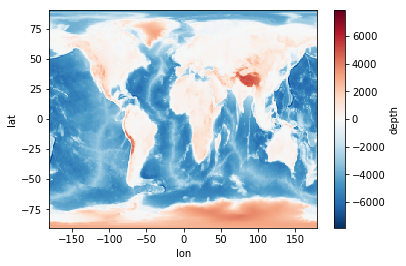

In [45]:
ds.depth.plot(x='lon',y='lat')

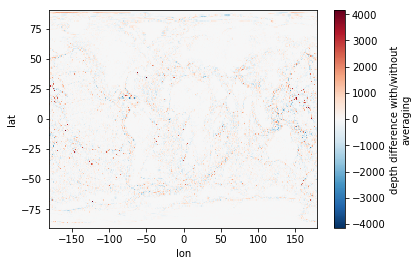

In [46]:
(depth_noav - ds.depth).rename('depth difference with/without averaging').plot(x='lon',y='lat')

---

## store dataset

In [47]:
# store
ds.to_netcdf(data_dir+'single_stats.nc', mode='w')
ds

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    U        (lon, lat) float64 nan nan nan nan ... nan -0.02582 0.2797 -0.0807
    V        (lon, lat) float64 nan nan nan nan ... nan 0.1025 -0.0283 -0.053
    U2       (lon, lat) float64 nan nan nan nan ... nan 0.01712 0.07918 0.006512
    V2       (lon, lat) float64 nan nan nan nan ... 0.01571 0.0008749 0.002809
    UV       (lon, lat) float64 nan nan nan nan ... -0.001538 -0.008177 0.004277
    COUNT    (lon, lat) float64 nan nan nan nan nan nan ... nan nan 26.0 2.0 1.0
    depth    (lon, lat) float64 2.792e+03 2.983e+03 ... -2.728e+03 -4.22e+03

In [ ]:
cluster.close()